In [6]:
from pathlib import Path

path = Path("titanic")
if not path.exists(): #download and extract titanic tabular data if not exist yet in the folder
    import kaggle
    import zipfile
    kaggle.api.competition_download_cli(str(path)) 
    zipfile.ZipFile(f"{path}.zip").extractall(path)

100%|█████████████████████████████████████████████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 97.3kB/s]

In [356]:
import torch
import numpy as np
import pandas as pd

In [357]:
df = pd.read_csv(path/"train.csv")

In [358]:
df.isna().sum() #Find the sum of "NaN" (not a number) in the data

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [359]:
modes = df.mode().iloc[0] #Find the most common "value"
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [360]:
df.fillna(modes, inplace=True) #Fill NaN data with the modes (inplace mean modify the original dataframe)

In [361]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [362]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


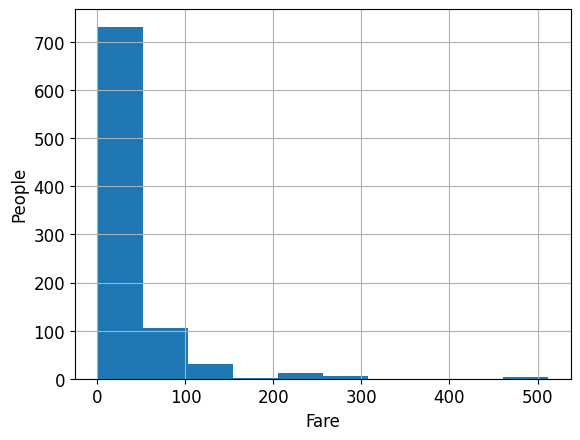

In [363]:
import matplotlib.pyplot as plt

plt.hist(df["Fare"]);
plt.grid()
plt.xlabel("Fare");
plt.ylabel("People");

# We have a "longtail" distrubition here so we should "log" it so that it normalize the "skewed" data

In [364]:
df["LogFare"] = np.log1p(df["Fare"]) # log1p = log(df["Fare"] + 1), bcz if a value = 0, log will give NaN

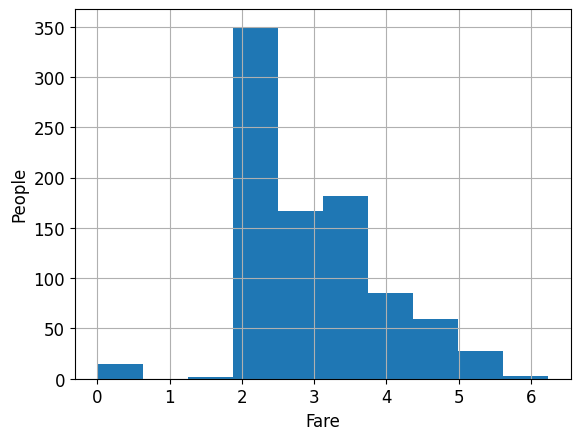

In [365]:
plt.hist(df["LogFare"]);
plt.grid()
plt.xlabel("Fare");
plt.ylabel("People");

In [366]:
df.describe(include=[object]) #Return the count of "unique"

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,B96 B98,S
freq,1,577,7,691,646


In [367]:
pclasses = sorted(df.Pclass.unique())
pclasses

[np.int64(1), np.int64(2), np.int64(3)]

In [368]:
#And because we cannot multiply "sex" or "embarked" with something else
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [369]:
added_cols = ['Sex_female', 'Sex_male', 'Pclass_1','Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()
# (head) Show the first 5 rows

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,False,True,False,False,True,False,False,True
1,True,False,True,False,False,True,False,False
2,True,False,False,False,True,False,False,True
3,True,False,True,False,False,False,False,True
4,False,True,False,False,True,False,False,True


In [370]:
#Now we got numbers so that we can multiply with coeff (False = 0, True = 1)

In [371]:
from torch import tensor
t_dep = tensor(df.Survived) #Set tensor dependent varible on the "Survived" (which is the thing we are trying to predict) 

In [372]:
indep_cols = ["Age", "SibSp", "Parch", "LogFare"] + added_cols
t_indep = tensor(df[indep_cols].astype(float).values, dtype=torch.float)
t_indep

tensor([[22.,  1.,  0.,  ...,  0.,  0.,  1.],
        [38.,  1.,  0.,  ...,  1.,  0.,  0.],
        [26.,  0.,  0.,  ...,  0.,  0.,  1.],
        ...,
        [24.,  1.,  2.,  ...,  0.,  0.,  1.],
        [26.,  0.,  0.,  ...,  1.,  0.,  0.],
        [32.,  0.,  0.,  ...,  0.,  1.,  0.]])

In [373]:
t_indep.shape

torch.Size([891, 12])

In [374]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff) - 0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [375]:
t_indep*coeffs #multiplying matrix (t_indep) with coeffs
#Here we use broadcasting

tensor([[-10.1838,   0.1386,   0.0000,  ...,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  ...,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  ...,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.1096,   0.1386,   0.4818,  ...,  -0.0000,   0.0000,   0.3625],
        [-12.0354,   0.0000,   0.0000,  ...,  -0.4392,   0.0000,   0.0000],
        [-14.8128,   0.0000,   0.0000,  ...,  -0.0000,   0.2103,   0.0000]])

In [376]:
#Age make the first ccolumn much "larger" comapred to other colum

In [377]:
vals, indices = t_indep.max(dim=0) #Find the max along the rows (dim=0)
t_indep = t_indep/vals

In [378]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000,  ..., -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000,  ..., -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1389,  0.0173,  0.0803,  ..., -0.0000,  0.0000,  0.3625],
        [-0.1504,  0.0000,  0.0000,  ..., -0.4392,  0.0000,  0.0000],
        [-0.1852,  0.0000,  0.0000,  ..., -0.0000,  0.2103,  0.0000]])

In [379]:
preds = (t_indep*coeffs).sum(axis=1)

In [380]:
preds[:10]

tensor([ 0.1412, -0.5725,  0.1494,  0.2571,  0.0453, -0.0448,  0.0792,  0.2961,  0.2128, -0.5770])

In [381]:
loss = torch.abs(preds - t_dep).mean()
loss

tensor(0.5200)

In [382]:
def calc_preds(coeffs, indep):
    return (indep*coeffs).sum(axis=1)
def calc_loss(coeffs, indep, dep):
    return torch.abs(calc_preds(coeffs, indep) - dep).mean()

In [383]:
coeffs.requires_grad_() #_ at the end of "grad" mean it is an inplace function

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [384]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5200, grad_fn=<MeanBackward0>)

In [385]:
loss.backward()

In [386]:
coeffs.grad

tensor([-0.0483,  0.0118, -0.0041, -0.0804, -0.1975,  0.1111, -0.1235, -0.0426,  0.0797, -0.1886, -0.0617,  0.1639])

In [387]:
lr = 0.1
with torch.no_grad():
    coeffs.sub_(coeffs.grad*lr)
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5056)


In [388]:
import fastbook
from fastai.data.transforms import RandomSplitter

In [389]:
train_split, valid_split = RandomSplitter(seed=42)(df)

In [390]:
train_indep, valid_indep = t_indep[train_split], t_indep[valid_split]
train_dep, valid_dep = t_dep[train_split], t_dep[valid_split]

In [391]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad*lr)

In [392]:
def epoch(coeffs, lr):
    loss = calc_loss(coeffs, train_indep, train_dep)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end = "| ")

In [393]:
def init_coeffs():
    return (torch.rand(n_coeff) - 0.5).requires_grad_()

In [394]:
def train_model(epochs = 30, lr = 0.1):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range (epochs):
        epoch(coeffs, lr)
    return coeffs

In [395]:
coeffs = train_model(20, lr = 0.01)

0.518| 0.517| 0.514| 0.510| 0.504| 0.498| 0.490| 0.482| 0.473| 0.464| 0.454| 0.442| 0.427| 0.410| 0.394| 0.378| 0.362| 0.348| 0.335| 0.322| 

In [396]:
def show_coeffs():
    return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2967),
 'SibSp': tensor(0.1170),
 'Parch': tensor(0.2507),
 'LogFare': tensor(0.0022),
 'Sex_female': tensor(0.1257),
 'Sex_male': tensor(-0.3620),
 'Pclass_1': tensor(0.7434),
 'Pclass_2': tensor(0.3916),
 'Pclass_3': tensor(0.2878),
 'Embarked_C': tensor(-0.0373),
 'Embarked_Q': tensor(0.3018),
 'Embarked_S': tensor(0.2110)}

# Measure accuracy

In [397]:
preds = calc_preds(coeffs, valid_indep)

In [398]:
results = valid_dep.bool() == (preds > 0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True, False, False, False, False,  True,  True, False])

In [399]:
results.float().mean()

tensor(0.7697)

In [400]:
def accuracy(coeffs):
    return (valid_dep.bool()==(calc_preds(coeffs, valid_indep)>0.5)).float().mean()
accuracy(coeffs)

tensor(0.7697)

# Using sigmoid because sometimes the predictions is > 1 or < 0

In [401]:
preds[:30]

tensor([ 0.7310,  0.1394, -0.1997,  0.1754,  0.1489,  0.1303,  0.4041,  0.6254,  0.2912,  0.3447,  0.0189, -0.1431,  0.1793,  0.6271,  0.0114,  0.4267,  0.3525,  0.6786,  0.0972,  0.5103,  0.0486,
         0.3859,  0.7452,  0.6500,  0.0634,  0.1544,  0.6781,  0.3636,  0.0746,  0.6271])

In [402]:
def calc_preds(coeffs, indep):
    return torch.sigmoid((coeffs*indep).sum(axis=1))
#Re define the predictions function with sigmoid adding in it

In [403]:
coeffs = train_model(lr = 2)

0.503| 0.461| 0.391| 0.336| 0.306| 0.285| 0.265| 0.245| 0.228| 0.217| 0.210| 0.206| 0.205| 0.204| 0.204| 0.204| 0.204| 0.205| 0.205| 0.205| 0.205| 0.204| 0.204| 0.203| 0.202| 0.201| 0.200| 0.199| 0.197| 0.196| 

In [404]:
accuracy(coeffs)

tensor(0.8258)









# Try using matrix product

### (valid_indep * coeffs).sum(axis=1) is the same with valid_indep@coeffs

In [406]:
def calc_preds(coeffs, indep):
    return torch.sigmoid(indep@coeffs)

In [409]:
def init_coeffs():
    return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

In [410]:
train_dep = train_dep[:, None] #Create another"dimension" by indexing a "non -existent" dimension
valid_dep = valid_dep[:, None]

# Create a neural network

In [413]:
def init_coeffs(n_hiddens=20):
    layer1 = (torch.rand(n_coeff, n_hiddens)-0.5)/n_hiddens
    layer2 = torch.rand(n_hiddens, 1) - 0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

In [421]:
import torch.nn.functional as F

def calc_preds(coeffs, indep):
    l1,l2,const = coeffs
    res = F.relu(indep@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [422]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad*lr)

In [423]:
coeffs = train_model(lr=1.4)

0.544| 0.533| 0.511| 0.467| 0.392| 0.302| 0.252| 0.225| 0.209| 0.203| 0.201| 0.200| 0.196| 0.193| 0.192| 0.192| 0.192| 0.192| 0.192| 0.192| 0.192| 0.192| 0.192| 0.192| 0.192| 0.192| 0.192| 0.192| 0.192| 0.192| 

In [424]:
accuracy(coeffs)

tensor(0.8258)

# Try with more layers

In [442]:
def init_coeffs():
    hiddens = [10, 10]
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1]) - 0.3) / sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers + consts:
        l.requires_grad_()
    return layers, consts

In [443]:
def calc_preds(coeffs, indep):
    layers, consts = coeffs
    n = len(layers)
    res = indep
    for index, layer in enumerate(layers):
        res = res@layer + consts[index]
        if index != n-1:
            res = F.relu(res)
    return torch.sigmoid(res)

In [444]:
def update_coeffs(coeffs, lr):
    layers, consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad*lr)

In [445]:
coeffs = train_model(lr = 1.4)

0.514| 0.463| 0.348| 0.318| 0.208| 0.220| 0.224| 0.223| 0.217| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 0.215| 

In [446]:
accuracy(coeffs)

tensor(0.7921)